In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import os
import seaborn as sns
%matplotlib inline

import pywt
import scipy
from scipy import signal
from scipy.signal import butter, deconvolve

In [2]:
test_path = os.path.join('..','data','test.csv')
train_path = os.path.join('..','data','train.csv')

test_df = pd.read_csv(test_path)
train_df = pd.read_csv(train_path)

In [3]:
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise_signal(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    return pywt.waverec(coeff, wavelet, mode='per')

In [4]:
time_train = train_df.time
signal_train_denoised = denoise_signal(train_df.signal)
open_channels_train = train_df.open_channels

data = {
    'time': time_train,
    'signal_denoised': signal_train_denoised,
    'open_channels_train': open_channels_train
       }

train_data = pd.DataFrame(data=data)
train_data

,time,signal_denoised,open_channels_train
0,0.0001,-2.497504,0
1,0.0002,-3.543952,0
2,0.0003,-0.952305,0
3,0.0004,-1.326738,0
4,0.0005,-3.603200,0
...,...,...,...
4999995,499.9996,3.296552,7
4999996,499.9997,3.586595,7
4999997,499.9998,3.957363,8
4999998,499.9999,4.474106,9


In [5]:
# train_data.signal_denoised.hist(bins=1000, figsize=(15,10))

In [6]:
# train_data
# fig, axes = plt.subplots(figsize=(20,15))

# axes.scatter(train_data.time.values, train_data.signal_denoised.values, c=train_data.open_channels_train.values, alpha=0.5 );
# axes.set_xlabel('time')
# axes.set_ylabel('signal denoised')
# axes.legend()#(list(train_data.open_channels_train.unique()));

In [7]:
from sklearn.model_selection import train_test_split

X = train_data.drop('open_channels_train',axis=1)
y = train_data.open_channels_train.values.reshape(-1,1).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
y_train

array([1, 2, 3, ..., 7, 2, 1])

In [9]:
from sklearn.preprocessing import QuantileTransformer, StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
X_scaler = StandardScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

In [10]:
X_train_scaled.shape

(4000000, 2)

In [11]:
y_train_categorical

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                150       
                                                                 
 dense_1 (Dense)             (None, 100)               5100      
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 25)                1275      
                                                                 
 dense_4 (Dense)             (None, 11)                286       
                                                                 
Total params: 11,861
Trainable params: 11,861
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20


2022-07-03 20:16:28.511021: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


125000/125000 [==============================] - 92s 736us/step - loss: 0.7978 - accuracy: 0.6410
Epoch 2/20
125000/125000 [==============================] - 90s 721us/step - loss: 0.7608 - accuracy: 0.6557
Epoch 3/20
125000/125000 [==============================] - 92s 737us/step - loss: 0.7550 - accuracy: 0.6578
Epoch 4/20
125000/125000 [==============================] - 90s 720us/step - loss: 0.7515 - accuracy: 0.6593
Epoch 5/20
125000/125000 [==============================] - 89s 716us/step - loss: 0.7498 - accuracy: 0.6598
Epoch 6/20
125000/125000 [==============================] - 90s 719us/step - loss: 0.7482 - accuracy: 0.6603
Epoch 7/20
125000/125000 [==============================] - 94s 749us/step - loss: 0.7470 - accuracy: 0.6608
Epoch 8/20
125000/125000 [==============================] - 95s 758us/step - loss: 0.7460 - accuracy: 0.6611
Epoch 9/20
125000/125000 [==============================] - 94s 752us/step - loss: 0.7455 - accuracy: 0.6613
Epoch 10/20
125000/125000 [===

<AxesSubplot:>

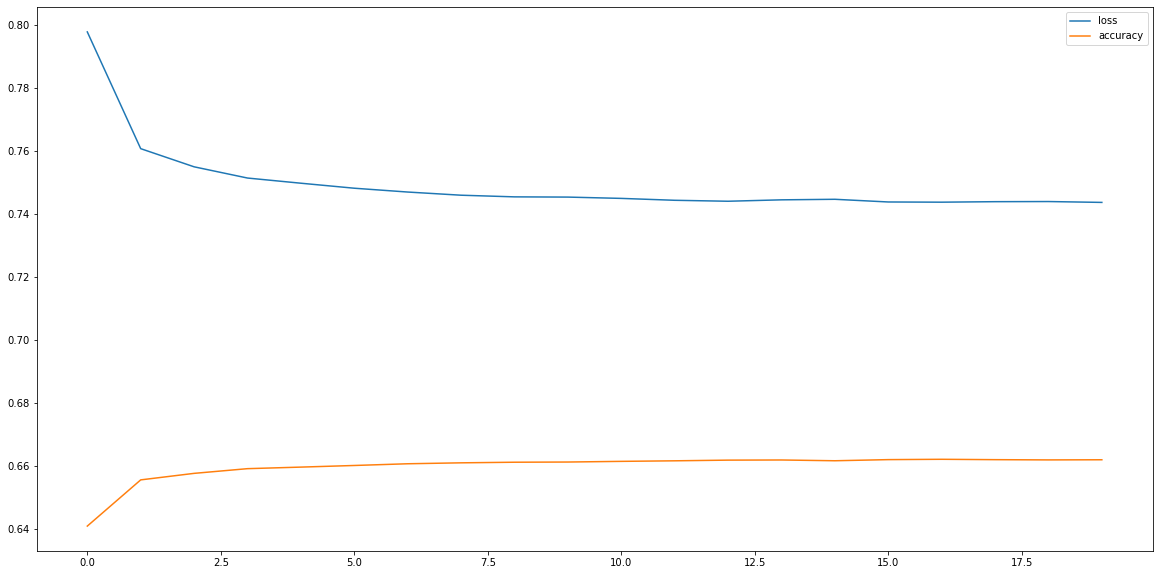

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(units=50, activation='relu', input_dim=X_train_scaled.shape[1]))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=25, activation='relu'))
model.add(Dense(units=11, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())

history = model.fit(
    X_train_scaled,
    y_train_categorical,
    epochs=20,
    shuffle=True,
    verbose=1
)

pd.DataFrame(history.history).plot(figsize=(20,10))

# print('\n----------------------------------------------------------------\n')

# model_loss, model_accuracy = model.evaluate(
#     X_test_scaled, y_test_categorical, verbose=2)
# print(f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

# encoded_predictions = model.predict_classes(X_test_scaled[:100])
# prediction_labels = label_encoder.inverse_transform(encoded_predictions)

# print(f'''
# Predicted classes: {list([i for i in prediction_labels])}
# Actual Labels: {[i for i in y_test[:100]]}
# ''')